In [235]:
"""
This code explains how to use kenkenpa based on LangGraph's "How to create branches for parallel node execution".
Some parts of the code are borrowed from the code at the following URL.
https://langchain-ai.github.io/langgraph/how-tos/branching/

In this section, we will predefine all the nodes used in the following four examples described in this How-to Guide,
and construct and execute an agent while switching GraphSettings at runtime.
- Parallel node fan-out and fan-in
- Parallel node fan-out and fan-in with extra steps
- Conditional Branching
- Stable Sorting
"""
import operator
from typing import Any

from kenkenpa.builder import StateGraphBuilder


In [236]:
# Definition of Nodes
# - ReturnNodeValue
# - ParallelReturnNodeValue
# - AggregateFanoutValues

In [237]:
class ReturnNodeValue():
    def __init__(self, factory_parameter,flow_parameter):
        self._value = factory_parameter['node_secret']
    def __call__(self, state ) -> Any:
        print(f"Adding {self._value} to {state['aggregate']}")
        return {"aggregate": [self._value]}

In [238]:
class ParallelReturnNodeValue():
    def __init__(self, factory_parameter,flow_parameter):
        self._value:str = factory_parameter['node_secret']
        self._reliability:float = factory_parameter['reliability']
    
    def __call__(self, state) -> Any:
        print(f"Adding {self._value} to {state['aggregate']} in parallel.")
        return {
            "fanout_values": [
                {
                    "value": [self._value],
                    "reliability": self._reliability,
                }
            ]
        }

In [239]:
class AggregateFanoutValues():
    def __init__(self, factory_parameter,flow_parameter):
        pass
    
    def __call__(self, state) -> Any:
        #Sort by reliability
        ranked_values = sorted(
            state["fanout_values"],key=lambda x: x["reliability"],reverse=True
        )
        return {
            "aggregate": [x["value"] for x in ranked_values] + ["I'm E"],
            "fanout_values": [],
        }

In [240]:
# Definition of Reducer
# - reduce_fanouts

In [241]:
def reduce_fanouts(left,right):
    if left is None:
        left = []
    if not right:
        return []
    return left + right

In [242]:
# Map the previously defined reducers and factories (defined as classes in this example code) to a dictionary.
# This dictionary is passed when creating an instance of StateGraphBuilder.
reducer_map = {
    "add":operator.add,
    "reduce_fanouts":reduce_fanouts,
}

factory_map = {
    "ReturnNodeValue":ReturnNodeValue,
    "ParallelReturnNodeValue":ParallelReturnNodeValue,
    "AggregateFanoutValues":AggregateFanoutValues
}


In [243]:
# Map the graph definitions for the four examples
graph_settings = {}

In [244]:
graph_settings['fanout_fanin'] = {
    "graph_type":"stategraph",
    "flow_parameter":{
        "name":"Parallel-node",
        "state" : [
            {
                "field_name": "aggregate",
                "type": "list",
                "reducer":"add"
            },
        ],
    },
    "flows": [
        { # node a
            "graph_type":"node",
            "flow_parameter": {
                "name":"a",
                "factory":"ReturnNodeValue",
            },
            "factory_parameter" : {"node_secret":"I'm A"},
        },
        { # normal_edge START-> a
            "graph_type":"edge",
            "flow_parameter":{
                "start_key":"START",
                "end_key":"a"
            },
        },
        { # node b
            "graph_type":"node",
            "flow_parameter": {
                "name":"b",
                "factory":"ReturnNodeValue",
            },
            "factory_parameter" : {"node_secret":"I'm B"},
        },
        { # node c
            "graph_type":"node",
            "flow_parameter": {
                "name":"c",
                "factory":"ReturnNodeValue",
            },
            "factory_parameter" : {"node_secret":"I'm C"},
        },
        { # node d
            "graph_type":"node",
            "flow_parameter": {
                "name":"d",
                "factory":"ReturnNodeValue",
            },
            "factory_parameter" : {"node_secret":"I'm D"},
        },
        { # normal_edge a -> b
            "graph_type":"edge",
            "flow_parameter": {
                "start_key":"a",
                "end_key":"b"
            },
        },
        { # normal_edge a -> c
            "graph_type":"edge",
            "flow_parameter": {
                "start_key":"a",
                "end_key":"c"
            },
        },
        { # normal_edge [b,c] -> d
            "graph_type":"edge",
            "flow_parameter": {
                "start_key":["b","c"],
                "end_key":"d"
            },
        },
        { # normal_edge d -> END
            "graph_type":"edge",
            "flow_parameter": {
                "start_key":"d",
                "end_key":"END"
            },
        },
    ]
}

In [245]:
graph_settings['fo_fi_with_extra_steps'] = {
    "graph_type":"stategraph",
    "flow_parameter":{
        "name":"Parallel-node",
        "state" : [
            {
                "field_name": "aggregate",
                "type": "list",
                "reducer":"add"
            },
        ],
    },
    "flows": [
        { # node a
            "graph_type":"node",
            "flow_parameter": {
                "name":"a",
                "factory":"ReturnNodeValue",
            },
            "factory_parameter" : {"node_secret":"I'm A"},
        },
        { # normal_edge START-> a
            "graph_type":"edge",
            "flow_parameter":{
                "start_key":"START",
                "end_key":"a"
            },
        },
        { # node b
            "graph_type":"node",
            "flow_parameter": {
                "name":"b",
                "factory":"ReturnNodeValue",
            },
            "factory_parameter" : {"node_secret":"I'm B"},
        },
        { # node b2
            "graph_type":"node",
            "flow_parameter": {
                "name":"b2",
                "factory":"ReturnNodeValue",
            },
            "factory_parameter" : {"node_secret":"I'm B2"},
        },
        { # node c
            "graph_type":"node",
            "flow_parameter": {
                "name":"c",
                "factory":"ReturnNodeValue",
            },
            "factory_parameter" : {"node_secret":"I'm C"},
        },
        { # node d
            "graph_type":"node",
            "flow_parameter": {
                "name":"d",
                "factory":"ReturnNodeValue",
            },
            "factory_parameter" : {"node_secret":"I'm D"},
        },
        { # normal_edge a -> b
            "graph_type":"edge",
            "flow_parameter": {
                "start_key":"a",
                "end_key":"b"
            },
        },
        { # normal_edge b -> b2
            "graph_type":"edge",
            "flow_parameter": {
                "start_key":"b",
                "end_key":"b2"
            },
        },
        { # normal_edge a -> c
            "graph_type":"edge",
            "flow_parameter": {
                "start_key":"a",
                "end_key":"c"
            },
        },
        { # normal_edge [b2,c] -> d
            "graph_type":"edge",
            "flow_parameter": {
                "start_key":["b2","c"],
                "end_key":"d"
            },
        },
        { # normal_edge d -> END
            "graph_type":"edge",
            "flow_parameter": {
                "start_key":"d",
                "end_key":"END"
            },
        },
    ]
}

In [246]:

graph_settings['conditional_branching'] = {
    "graph_type":"stategraph",
    "flow_parameter":{
        "name":"Parallel-node",
        "state" : [
            {
                "field_name": "aggregate",
                "type": "list",
                "reducer":"add"
            },
            {
                "field_name": "which",
                "type": "str",
            },
        ],
    },
    "flows": [
        { # node a
            "graph_type":"node",
            "flow_parameter": {
                "name":"a",
                "factory":"ReturnNodeValue",
            },
            "factory_parameter" : {"node_secret":"I'm A"},
        },
        { # normal_edge START-> a
            "graph_type":"edge",
            "flow_parameter":{
                "start_key":"START",
                "end_key":"a"
            },
        },
        { # node b
            "graph_type":"node",
            "flow_parameter": {
                "name":"b",
                "factory":"ReturnNodeValue",
            },
            "factory_parameter" : {"node_secret":"I'm B"},
        },
        { # node c
            "graph_type":"node",
            "flow_parameter": {
                "name":"c",
                "factory":"ReturnNodeValue",
            },
            "factory_parameter" : {"node_secret":"I'm C"},
        },
        { # node d
            "graph_type":"node",
            "flow_parameter": {
                "name":"d",
                "factory":"ReturnNodeValue",
            },
            "factory_parameter" : {"node_secret":"I'm D"},
        },
        { # node e
            "graph_type":"node",
            "flow_parameter": {
                "name":"e",
                "factory":"ReturnNodeValue",
            },
            "factory_parameter" : {"node_secret":"I'm E"},
        },
        { # conditional edge a -> b,c or c,d
            "graph_type":"configurable_conditional_edge",
            "flow_parameter":{
                "start_key":"a",
                "conditions":[
                    {
                        "expression": {
                            "eq": [{"type": "state_value", "name": "which"}, "cd"],
                        },
                        "result": ["c","d"]
                    },
                    {"default": ["b","c"]}
                ]
            },
        },
        { # normal_edge b,c,d -> e
            "graph_type":"edge",
            "flow_parameter": {
                "start_key":["b","c","d"],
                "end_key":"e"
            },
        },
        { # normal_edge e -> END
            "graph_type":"edge",
            "flow_parameter": {
                "start_key":"e",
                "end_key":"END"
            },
        },
    ]
}

In [247]:

graph_settings['stable_sorting'] = {
    "graph_type":"stategraph",
    "flow_parameter":{
        "name":"Parallel-node",
        "state" : [
            {
                "field_name": "aggregate",
                "type": "list",
                "reducer":"add"
            },
            {
                "field_name": "fanout_values",
                "type": "list",
                "reducer":"reduce_fanouts"
            },
            {
                "field_name": "which",
                "type": "str",
            },
        ],
    },
    "flows": [
        { # node a
            "graph_type":"node",
            "flow_parameter": {
                "name":"a",
                "factory":"ReturnNodeValue",
            },
            "factory_parameter" : {"node_secret":"I'm A"},
        },
        { # normal_edge START-> a
            "graph_type":"edge",
            "flow_parameter":{
                "start_key":"START",
                "end_key":"a"
            },
        },
        { # conditional edge a -> b,c or c,d
            "graph_type":"configurable_conditional_edge",
            "flow_parameter":{
                "start_key":"a",
                "path_map":["b","c","d"],
                "conditions":[
                    {
                        "expression": {
                            "eq": [{"type": "state_value", "name": "which"}, "cd"],
                        },
                        "result": ["c","d"]
                    },
                    {"default": ["b","c"]}
                ]
            },
        },
        { # node b
            "graph_type":"node",
            "flow_parameter": {
                "name":"b",
                "factory":"ParallelReturnNodeValue",
            },
            "factory_parameter" : {
                "node_secret":"I'm B",
                "reliability":0.9,
                },
        },
        { # node c
            "graph_type":"node",
            "flow_parameter": {
                "name":"c",
                "factory":"ParallelReturnNodeValue",
            },
            "factory_parameter" : {
                "node_secret":"I'm C",
                "reliability":0.1,
                },
        },
        { # node d
            "graph_type":"node",
            "flow_parameter": {
                "name":"d",
                "factory":"ParallelReturnNodeValue",
            },
            "factory_parameter" : {
                "node_secret":"I'm D",
                "reliability":0.3,
                },
        },
        { # node e
            "graph_type":"node",
            "flow_parameter": {
                "name":"e",
                "factory":"AggregateFanoutValues",
            },
        },
        { # normal_edge [b,c,d] -> e
            "graph_type":"edge",
            "flow_parameter": {
                "start_key":["b","c","d"],
                "end_key":"e"
            },
        },
        { # normal_edge e -> END
            "graph_type":"edge",
            "flow_parameter": {
                "start_key":"e",
                "end_key":"END"
            },
        },
    ]
}

In [248]:
# Preparation is now complete.
# From here, we will execute the examples from the how-to guides.

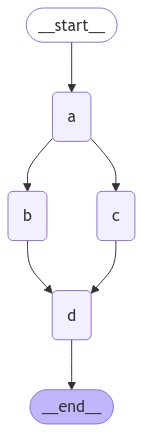

In [249]:
# Parallel node fan-out and fan-in
stategraph_builder = StateGraphBuilder(
    graph_settings=graph_settings['fanout_fanin'] ,
    node_factorys=factory_map,
    reducers=reducer_map
    )

# The gen_stategraph method generates a compilable StateGraph.
fofi_stategraph = stategraph_builder.gen_stategraph()

# From here on, we will write the code following the general usage of LangGraph.
graph = fofi_stategraph.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))


In [250]:
graph.invoke({"aggregate": []}, {"configurable": {"thread_id": "foo"}})


Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm D to ["I'm A", "I'm B", "I'm C"]


{'aggregate': ["I'm A", "I'm B", "I'm C", "I'm D"]}

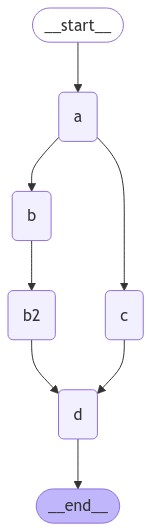

In [251]:
# Parallel node fan-out and fan-in with extra steps
stategraph_builder = StateGraphBuilder(
    graph_settings=graph_settings['fo_fi_with_extra_steps'],
    node_factorys=factory_map,
    reducers=reducer_map
    )

# The gen_stategraph method generates a compilable StateGraph.
fofies_stategraph = stategraph_builder.gen_stategraph()

# From here on, we will write the code following the general usage of LangGraph.
graph = fofies_stategraph.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))


In [252]:
graph.invoke({"aggregate": []}, {"configurable": {"thread_id": "foo"}})


Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm B2 to ["I'm A", "I'm B", "I'm C"]
Adding I'm D to ["I'm A", "I'm B", "I'm C"]
Adding I'm D to ["I'm A", "I'm B", "I'm C", "I'm B2", "I'm D"]


{'aggregate': ["I'm A", "I'm B", "I'm C", "I'm B2", "I'm D", "I'm D"]}

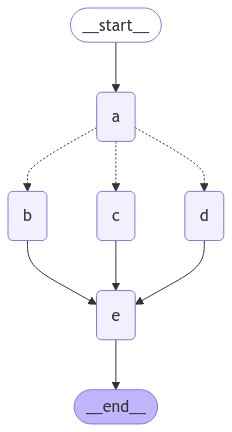

In [253]:
# Conditional Branching
stategraph_builder = StateGraphBuilder(
    graph_settings=graph_settings['conditional_branching'],
    node_factorys=factory_map,
    reducers=reducer_map
    )

# The gen_stategraph method generates a compilable StateGraph.
stategraph = stategraph_builder.gen_stategraph()

# From here on, we will write the code following the general usage of LangGraph.
graph = stategraph.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))


In [254]:
graph.invoke({"aggregate": [],"which":"bc"}, {"configurable": {"thread_id": "foo"}})


Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm E to ["I'm A", "I'm B", "I'm C"]


{'aggregate': ["I'm A", "I'm B", "I'm C", "I'm E"], 'which': 'bc'}

In [255]:
graph.invoke({"aggregate": [],"which":"cd"}, {"configurable": {"thread_id": "foo"}})


Adding I'm A to []
Adding I'm C to ["I'm A"]
Adding I'm D to ["I'm A"]
Adding I'm E to ["I'm A", "I'm C", "I'm D"]


{'aggregate': ["I'm A", "I'm C", "I'm D", "I'm E"], 'which': 'cd'}

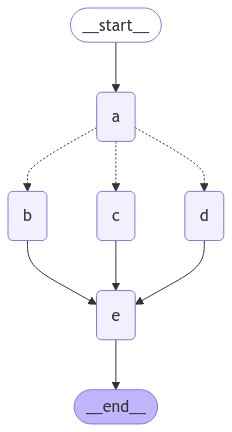

In [256]:
# Stable Sorting
stategraph_builder = StateGraphBuilder(
    graph_settings=graph_settings['stable_sorting'],
    node_factorys=factory_map,
    reducers=reducer_map
    )

# The gen_stategraph method generates a compilable StateGraph.
stable_sorting_stategraph = stategraph_builder.gen_stategraph()

# From here on, we will write the code following the general usage of LangGraph.
graph = stable_sorting_stategraph.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))


In [257]:
graph.invoke({"aggregate": [], "which": "bc", "fanout_values": []})

Adding I'm A to []
Adding I'm B to ["I'm A"] in parallel.
Adding I'm C to ["I'm A"] in parallel.


{'aggregate': ["I'm A", ["I'm B"], ["I'm C"], "I'm E"],
 'fanout_values': [],
 'which': 'bc'}

In [258]:
graph.invoke({"aggregate": [], "which": "cd"})

Adding I'm A to []
Adding I'm C to ["I'm A"] in parallel.
Adding I'm D to ["I'm A"] in parallel.


{'aggregate': ["I'm A", ["I'm D"], ["I'm C"], "I'm E"],
 'fanout_values': [],
 'which': 'cd'}